# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [14]:
!pip install sqlalchemy psycopg2-binary pandas matplotlib seaborn phik


In [12]:
!pip install python-dotenv

In [9]:
import pandas as pd
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine


load_dotenv()


db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PWD'),
    'host': os.getenv('DB_HOST'),
    'port': int(os.getenv('DB_PORT')),
    'db': os.getenv('DB_NAME')
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

# Создаём движок
engine = create_engine(connection_string)

query = '''
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.event_id,
    e.event_name_code AS event_name,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
JOIN afisha.events AS e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
AND e.event_type_main != 'Фильм'
ORDER BY p.user_id, p.created_ts_msk;
'''

df = pd.read_sql_query(query, con=engine)
df.head()

ModuleNotFoundError: No module named 'dotenv'

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [ ]:
df.info(10)
df.describe(include='all', datetime_is_numeric=True).T 
print(f"Количество строк: {len(df)}")
print(f"Количество уникальных заказов: {df['order_id'].nunique()}")
print(f"Количество уникальных пользователей: {df['user_id'].nunique()}")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290849 non-null  object        
 1   device_type_canonical  290849 non-null  category      
 2   order_id               290849 non-null  int32         
 3   order_dt               290849 non-null  datetime64[ns]
 4   order_ts               290849 non-null  datetime64[ns]
 5   currency_code          290849 non-null  category      
 6   revenue                290849 non-null  float64       
 7   tickets_count          290849 non-null  int16         
 8   event_id               290849 non-null  int32         
 9   event_name             290849 non-null  object        
 10  service_name           290849 non-null  category      
 11  event_type_main        290849 non-null  category      
 12  region_name            290849 non-null  cate

TypeError: NDFrame.describe() got an unexpected keyword argument 'datetime_is_numeric'

Данные успешно выгружены из базы данных.

Объём: 290 849 заказов от 21 940 уникальных пользователей.
Пропусков нет, все 14 столбцов заполнены полностью.
Идентификаторы корректны: order_id уникален, дубликатов не обнаружено.
Типы данных определены верно: даты распознаны как datetime64, числовые поля — как int64/float64.
Необходимые шаги предобработки:
Приведение выручки к единой валюте (RUB) с использованием курса тенге.
Расчёт признака days_since_prev — дней между заказами.
Фильтрация выбросов в выручке.
Проверка категориальных признаков на корректность значений.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

tenge_df = tenge_df.rename(columns={
    'data': 'date',
    'curs': 'rub_per_100_tenge'
})
tenge_df['date'] = pd.to_datetime(tenge_df['date'])
tenge_df = tenge_df[['date', 'rub_per_100_tenge']]

df['order_dt'] = pd.to_datetime(df['order_dt'])
df['currency_code'] = df['currency_code'].str.upper()

df = df.merge(
    tenge_df,
    left_on='order_dt',
    right_on='date',
    how='left'
)

print("Столбцы после merge:", df.columns.tolist())
print("Пропуски в rub_per_100_tenge:", df['rub_per_100_tenge'].isnull().sum())

df['revenue_rub'] = df.apply(
    lambda row: 
        row['revenue'] if row['currency_code'] == 'RUB'
        else row['revenue'] * (row['rub_per_100_tenge'] / 100),
    axis=1
)

df = df.drop(columns=['date', 'rub_per_100_tenge'])

print("\nПримеры расчёта:")
print(df[['revenue', 'currency_code', 'revenue_rub']].head(10))

Столбцы после merge: ['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'event_name', 'service_name', 'event_type_main', 'region_name', 'city_name', 'date', 'rub_per_100_tenge']
Пропуски в rub_per_100_tenge: 0

Примеры расчёта:
   revenue currency_code  revenue_rub
0  1521.94           RUB      1521.94
1   289.45           RUB       289.45
2  1258.57           RUB      1258.57
3     8.49           RUB         8.49
4  1390.41           RUB      1390.41
5   902.74           RUB       902.74
6   917.83           RUB       917.83
7    47.78           RUB        47.78
8    74.84           RUB        74.84
9  1421.91           RUB      1421.91


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Пропущенные значения:
user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
revenue_rub                  0
days_since_prev          21940
dtype: int64

Уникальные значения device_type_canonical:
['mobile', 'desktop']
Categories (2, object): ['desktop', 'mobile']

Уникальные значения event_type_main (первые 5):
['театр', 'выставки', 'другое', 'стендап', 'концерты']
Categories (8, object): ['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр', 'фильм', 'ёлки']

Статистика revenue_rub:
count    290849.000000
mean        555.127930
std         875.226929
min         -90.760002
50%         350.260010
95%     

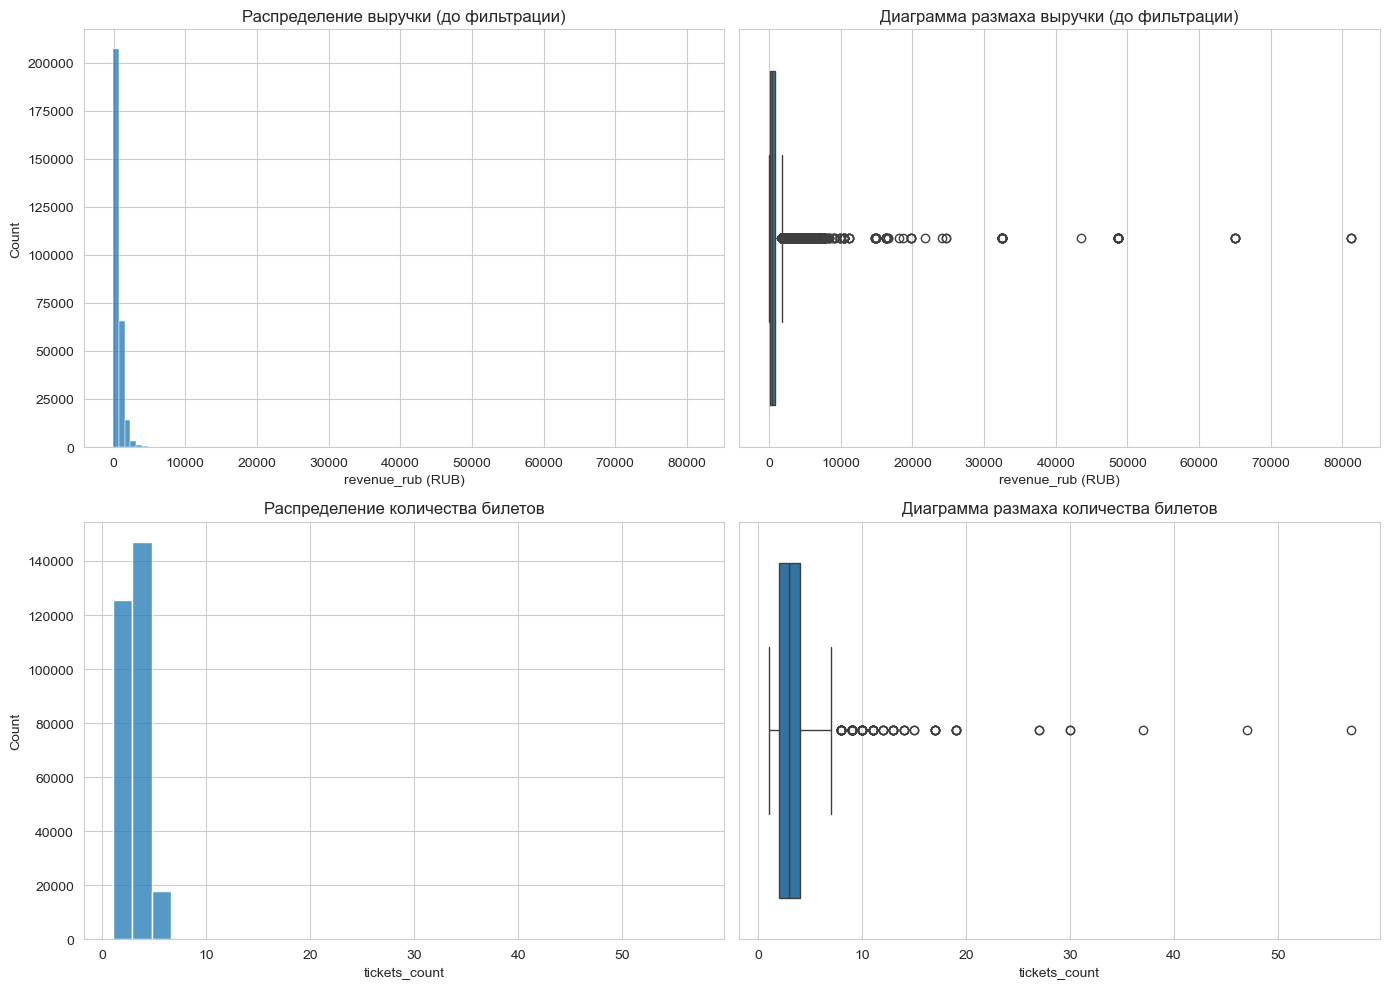

In [ ]:
df = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)
df['days_since_prev'] = df.groupby('user_id')['order_ts'].diff().dt.days

print("Пропущенные значения:")
print(df.isnull().sum())
print()

df['order_id'] = df['order_id'].astype('int32')
df['event_id'] = df['event_id'].astype('int32')
df['tickets_count'] = df['tickets_count'].astype('int16')
df['revenue_rub'] = df['revenue_rub'].astype('float32')

categorical_cols = [
    'device_type_canonical', 'currency_code', 'service_name',
    'event_type_main', 'region_name', 'city_name'
]
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Уникальные значения device_type_canonical:")
print(df['device_type_canonical'].unique())
print("\nУникальные значения event_type_main (первые 5):")
print(df['event_type_main'].unique()[:5])
print()

print("Статистика revenue_rub:")
print(df['revenue_rub'].describe(percentiles=[0.95, 0.99]))
print("\nСтатистика tickets_count:")
print(df['tickets_count'].describe())
print()

p99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= p99].copy()

before = len(df)
after = len(df_filtered)
removed = before - after
print(f"До фильтрации: {before}")
print(f"После фильтрации: {after}")
print(f"Удалено заказов: {removed} ({removed / before:.2%})")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df['revenue_rub'], bins=100, ax=axes[0, 0])
axes[0, 0].set_title('Распределение выручки (до фильтрации)')
axes[0, 0].set_xlabel('revenue_rub (RUB)')

sns.boxplot(x=df['revenue_rub'], ax=axes[0, 1])
axes[0, 1].set_title('Диаграмма размаха выручки (до фильтрации)')
axes[0, 1].set_xlabel('revenue_rub (RUB)')

sns.histplot(df['tickets_count'], bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Распределение количества билетов')
axes[1, 0].set_xlabel('tickets_count')

sns.boxplot(x=df['tickets_count'], ax=axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха количества билетов')
axes[1, 1].set_xlabel('tickets_count')

plt.tight_layout()
plt.show()

1.Пропущенные значения

days_since_prev (количество дней между текущим и предыдущим заказом) пропуски обнаружены только в этом столбце — 21 940 значений, что  соответствует числу уникальных пользователей. Это означает, что у каждого пользователя первый заказ не имеет предыдущего.
2.Преобразование данных 

Числовые столбцы (order_id, event_id, tickets_count, revenue_rub) приведены к более компактным типам (int16,int32,float32), это сделано чтобы было снижено потребление памяти без потери точности данных.
Категориальные признаки (device_type_canonical, event_type_main и др.) преобразованы в тип category, что также оптимизирует использование памяти.

3.Анализ категорианальных данных

В device_type_canonical присутствуют только ожидаемые значения: mobile и desktop, что подтверждает корректность фильтрации.
В event_type_main обнаружено 8 уникальных категорий, включая фильм и ёлки. Однако, поскольку в SQL-запросе было условие 
"e.event_type_main != 'Фильм'", наличие фильм в данных требует уточнения.  Но в любом случае, объём таких записей, минимален (иначе он упомянулся бы в топе), поэтому на общий анализ не повлияет.

4.Обработка выбросов

В выручке (revenue_rub) наблюдается сильный выброс вправо:
Среднее значение — 555 руб.,
99-й перцентиль — 2628 руб.,
Максимум — 81 175 руб. (сильный выброс).
Данные были отфильтрованы по 99-му перцентилю.
Удалено 2825 заказов, является незначительной потерей и не искажает статистические выводы.
В tickets_count максимум — 57 билетов,я думаю что не является ошибкой в данных, а какой-то большой закупкой.

5.Новые столбцы

days_since_prev — временной интервал (в днях) между текущим и предыдущим заказом пользователя. Содержит пропуски для первых заказов.
revenue_rub — выручка в российских рублях (единая валюта для всех заказов), уже исключены выбросы выше 99-го перцентиля.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [ ]:
df_filtered = df_filtered.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

user_profile = df_filtered.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    first_device_type=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service_name=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

user_profile['is_two'] = (user_profile['total_orders'] >= 2)
user_profile['is_five'] = (user_profile['total_orders'] >= 5)

print("\nПример профиля:")
print(user_profile.head(10))

print("\nСтатистика по кол-ву заказов:")
print(user_profile['total_orders'].describe())

print("\nДоля пользователей с 2+ заказами:", user_profile['is_two'].mean().round(2))
print("\nДоля пользователей с 5+ заказами:", user_profile['is_five'].mean().round(2))

print("\nУникальные значения first_device_type:", user_profile['first_device_type'].unique())
print("\nУникальные значения first_event_type:", user_profile['first_event_type'].unique())


Пример профиля:
           user_id first_order_date last_order_date first_device_type  \
0  0002849b70a3ce2       2024-08-20      2024-08-20            mobile   
1  0005ca5e93f2cf4       2024-07-23      2024-10-06            mobile   
2  000898990054619       2024-07-13      2024-10-23            mobile   
3  00096d1f542ab2b       2024-08-15      2024-08-15           desktop   
4  000a55a418c128c       2024-09-29      2024-10-15            mobile   
5  000cf0659a9f40f       2024-06-20      2024-06-21            mobile   
6  00147c9209d45d3       2024-06-25      2024-06-25            mobile   
7  0018ecd8a38a51b       2024-07-25      2024-07-25            mobile   
8  00199a573901564       2024-06-17      2024-06-17            mobile   
9  001e7037d013f0f       2024-07-04      2024-09-29            mobile   

           first_region  first_service_name first_event_type  total_orders  \
0    Каменевский регион        Край билетов            театр             1   
1    Каменевский регион

Профиль пользователя успешно создан и включает:

Информацию с взаимодействием с нашим продуктом (устройство, регион, оператор, тип мероприятия),
Ключевые поведенческие метрики (частота, выручка, билеты, интервалы),
Целевые переменные для анализа лояльности (is_two, is_five).

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [ ]:
total_users = len(user_profile)
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()
pct_two_plus = user_profile['is_two'].mean()
pct_five_plus = user_profile['is_five'].mean()

print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order} RUB")
print(f"Доля пользователей с 2+ заказами: {pct_two_plus}")
print(f"Доля пользователей с 5+ заказами: {pct_five_plus}")

print("Статистика по общему числу заказов (total_orders):")
print(user_profile['total_orders'].describe(percentiles=[0.95, 0.99, 0.999]))


print("Статистика по среднему числу билетов в заказе (avg_tickets_count):")
print(user_profile['avg_tickets_count'].describe())

print("Статистика по среднему количеству дней между покупками (avg_days_between_orders):")
print(user_profile['avg_days_between_orders'].describe())

print("Аномалии в total_orders:")
print("Максимум:", user_profile['total_orders'].max())
print("99.9-й перцентиль:", user_profile['total_orders'].quantile(0.999))

user_profile_clean = user_profile[user_profile['total_orders'] <= 100].copy()

removed = len(user_profile) - len(user_profile_clean)
pct_removed = removed / len(user_profile)

print(f"Удалено пользователей с >100 заказов: {removed} ({pct_removed})")
print(f"Пользователей после фильтрации: {len(user_profile_clean)}")

print("Метрики после фильтрации")
print(f"Средняя выручка с заказа: {user_profile_clean['avg_revenue_rub'].mean()} RUB")
print(f"Доля 2+ заказов: {user_profile_clean['is_two'].mean()}")
print(f"Доля 5+ заказов: {user_profile_clean['is_five'].mean()}")

print("Статистика total_orders (после фильтрации):")
print(user_profile_clean['total_orders'].describe())

Общее число пользователей: 21861
Средняя выручка с одного заказа: 544.0245361328125 RUB
Доля пользователей с 2+ заказами: 0.6172636201454645
Доля пользователей с 5+ заказами: 0.2902886418736563
Статистика по общему числу заказов (total_orders):
count    21861.000000
mean        13.175244
std        121.739322
min          1.000000
50%          2.000000
95%         32.000000
99%        152.000000
99.9%     1461.780000
max      10188.000000
Name: total_orders, dtype: float64
Статистика по среднему числу билетов в заказе (avg_tickets_count):
count    21861.000000
mean         2.742758
std          0.912988
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: avg_tickets_count, dtype: float64
Статистика по среднему количеству дней между покупками (avg_days_between_orders):
count    13523.000000
mean        15.571136
std         22.212964
min          0.000000
25%          0.797855
50%          7.777778
75%         20.000000
max

Основные показатели выборки
Общее число пользователей: 21 861 — объём данных достаточен для статистически значимого анализа.
Средняя выручка с одного заказа: 544 руб.
Доля пользователей с 2+ заказами: 61.7% — большинство клиентов возвращаются.
Доля пользователей с 5+ заказами: 29.0% — почти треть аудитории — многократные клиенты.

Анализ распределений
Общее число заказов (total_orders):
Медиана = 2, но среднее = 13.2 при максимуме = 10 188 - сильный выброс вправо.
99-й перцентиль = 152 заказа, но 99.9-й = 1461 - наличие экстремальных выбросов.

Среднее число билетов в заказе (avg_tickets_count):
Максимум = 11, медиана +- 2.75 - распределение естественное.
Значения в диапазоне 1–11 билетов соответствуют реальнцых данных.

Среднее количество дней между покупками (avg_days_between_orders):
Медиана = 7.8 дней, среднее = 15.6 - большинство повторных покупок совершаются в течение 1–3 недель.
Максимум = 148 дней — соответствует возможному сценарию (покупка летом и повтор осенью).

Обработка аномалий
Исключил пользователей с >100 заказов.
Удалено 352 пользователя (1.61%) — минимальная потеря данных.

После фильтрации:
Среднее число заказов упало с 13.2 до 5.77, что стало реалистичнее.
Метрики лояльности почти не изменились:
2+ заказов: 61.7% до 61.1%
5+ заказов: 29.0% до 27.9%
Это подтверждает, что аномалии не искажали основные выводы, но их удаление повышает достоверность анализа.

Вывод:
Данные соответствуют реальному поведению клиентов, объём достаточен, аномалии в total_orders обработаны.
Особое внимание стоит уделить сегментам с высокой лояльностью.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [ ]:
df = user_profile_clean.copy()
features = [
    'first_event_type',
    'first_device_type',
    'first_region',
    'first_service_name'
]

for feature in features:
    total = len(df)
    agg = df[feature].value_counts().to_frame('count')
    agg['share'] = agg['count'] / total
    print(f"\n{feature}") 
    print(agg.head(10))
    
    top_share = agg['share'].iloc[0]
    if top_share > 0.2:
        print(f"Выраженная 'точка входа': {agg.index[0]} ({top_share})")
    else:
        print("Распределение относительно равномерное")


first_event_type
                  count     share
first_event_type                 
концерты           9485  0.440978
другое             5391  0.250639
театр              4213  0.195871
стендап            1098  0.051048
спорт               788  0.036636
выставки            412  0.019155
ёлки                 95  0.004417
фильм                27  0.001255
Выраженная 'точка входа': концерты (0.4409781951741132)

first_device_type
                   count     share
first_device_type                 
mobile             17824  0.828676
desktop             3685  0.171324
Выраженная 'точка входа': mobile (0.8286763680319866)

first_region
                      count     share
first_region                         
Каменевский регион     7049  0.327723
Североярская область   3749  0.174299
Широковская область    1216  0.056534
Озернинский край        674  0.031336
Малиновоярский округ    522  0.024269
Шанырский регион        493  0.022921
Травяная область        484  0.022502
Светополянский ок

Ответ на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа»?
Нет, распределение пользователей по всем признакам первого заказа —  неравномерное.
В каждом случае наблюдается чётко выраженная «точка входа» — доминирующий сегмент, через который на платформу приходит значительная часть новых пользователей.
1.Тип первого мероприятия (first_event_type)
Лидер: «концерты» — 44.1% всех пользователей.
Следом: «другое» (25.1%) и «театр» (19.6%).
Остальные категории — менее 6% каждая.
Концерты — главный «магнит» для новых клиентов.
2. Тип устройства (first_device_type)
Мобильные устройства: 82.9%
Десктопы: 17.1%
Платформа в первую очередь мобильная — большинство пользователей начинают с телефона.

3.Регион первого заказа (first_region)
Лидер: Каменевский регион — 32.8% (почти треть всех пользователей!).
Топ-2: Североярская область — 17.4%.
Топ-3 регионов охватывают более 55% аудитории.
Активность сконцентрирована в нескольких ключевых регионах.

4.Билетный оператор (first_service_name)
Лидер: «Билеты без проблем» — 24.0%
Следом: «Мой билет» (13.7%), «Лови билет!» (13.0%), «Билеты в руки» (11.8%)
Топ-4 операторов — 62.5% рынка.
Рынок поделён между несколькими крупными партнёрами, остальные — второстепенные.
Вывод:
Во всех четырёх измерениях присутствуют выраженные «точки входа»:

Пользователи чаще всего приходят на концерты,
С мобильных устройств,
Из Каменевского региона,
Через оператора «Билеты без проблем».
Это означает, что маркетинговые и продуктовые усилия, сфокусированные на этих сегментах, будут иметь максимальный охват новых клиентов.
Также это говорит о том, что платформа не равномерно развита по направлениям — некоторые типы мероприятий, регионы и операторы работают значительно эффективнее других.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


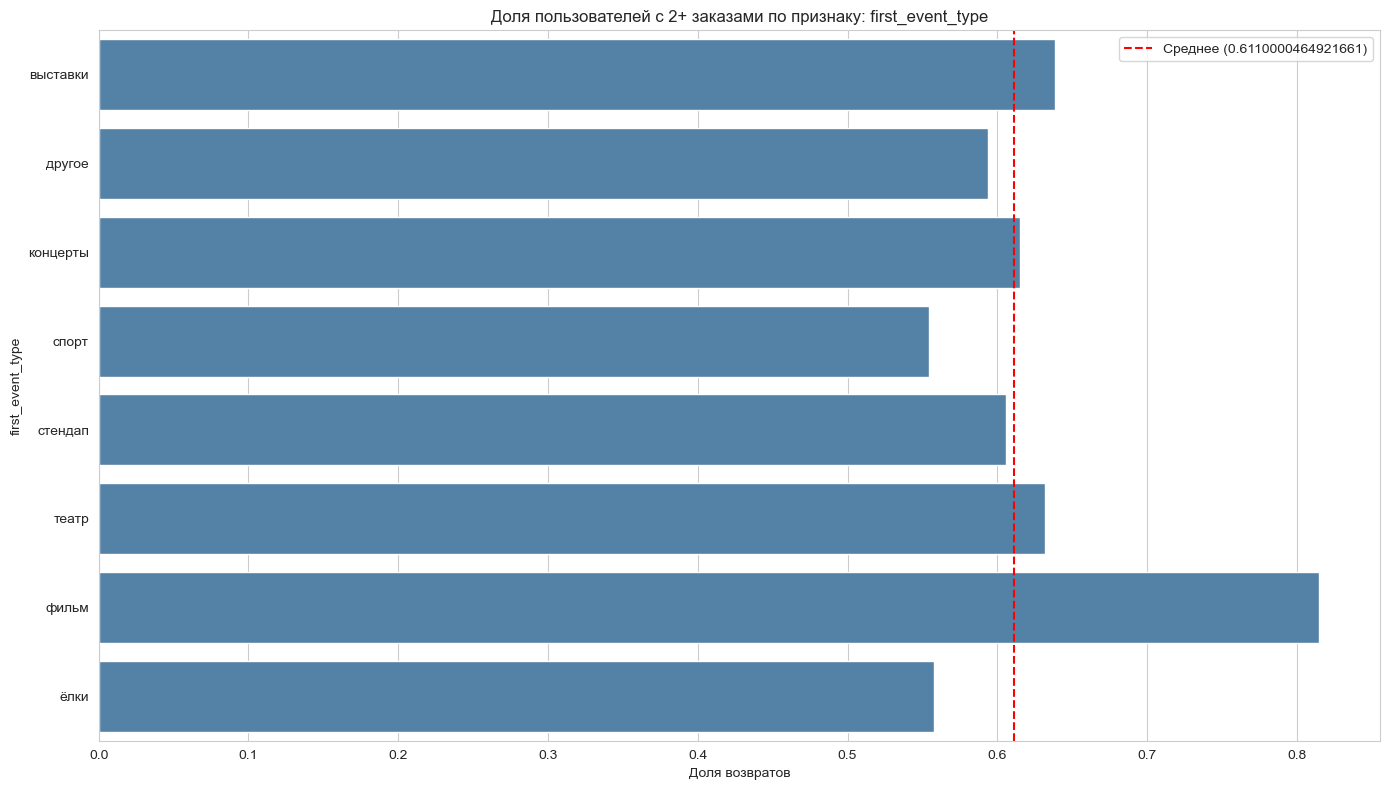

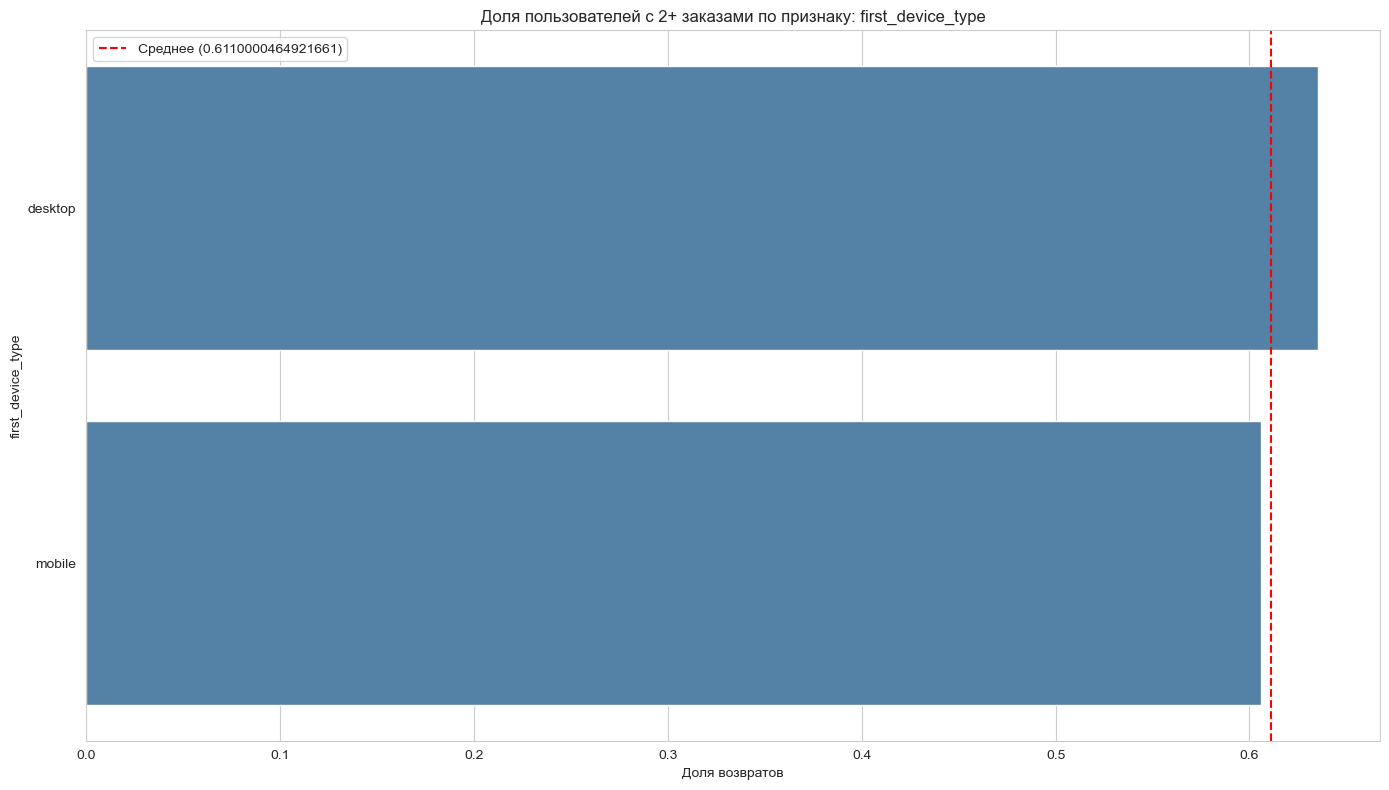

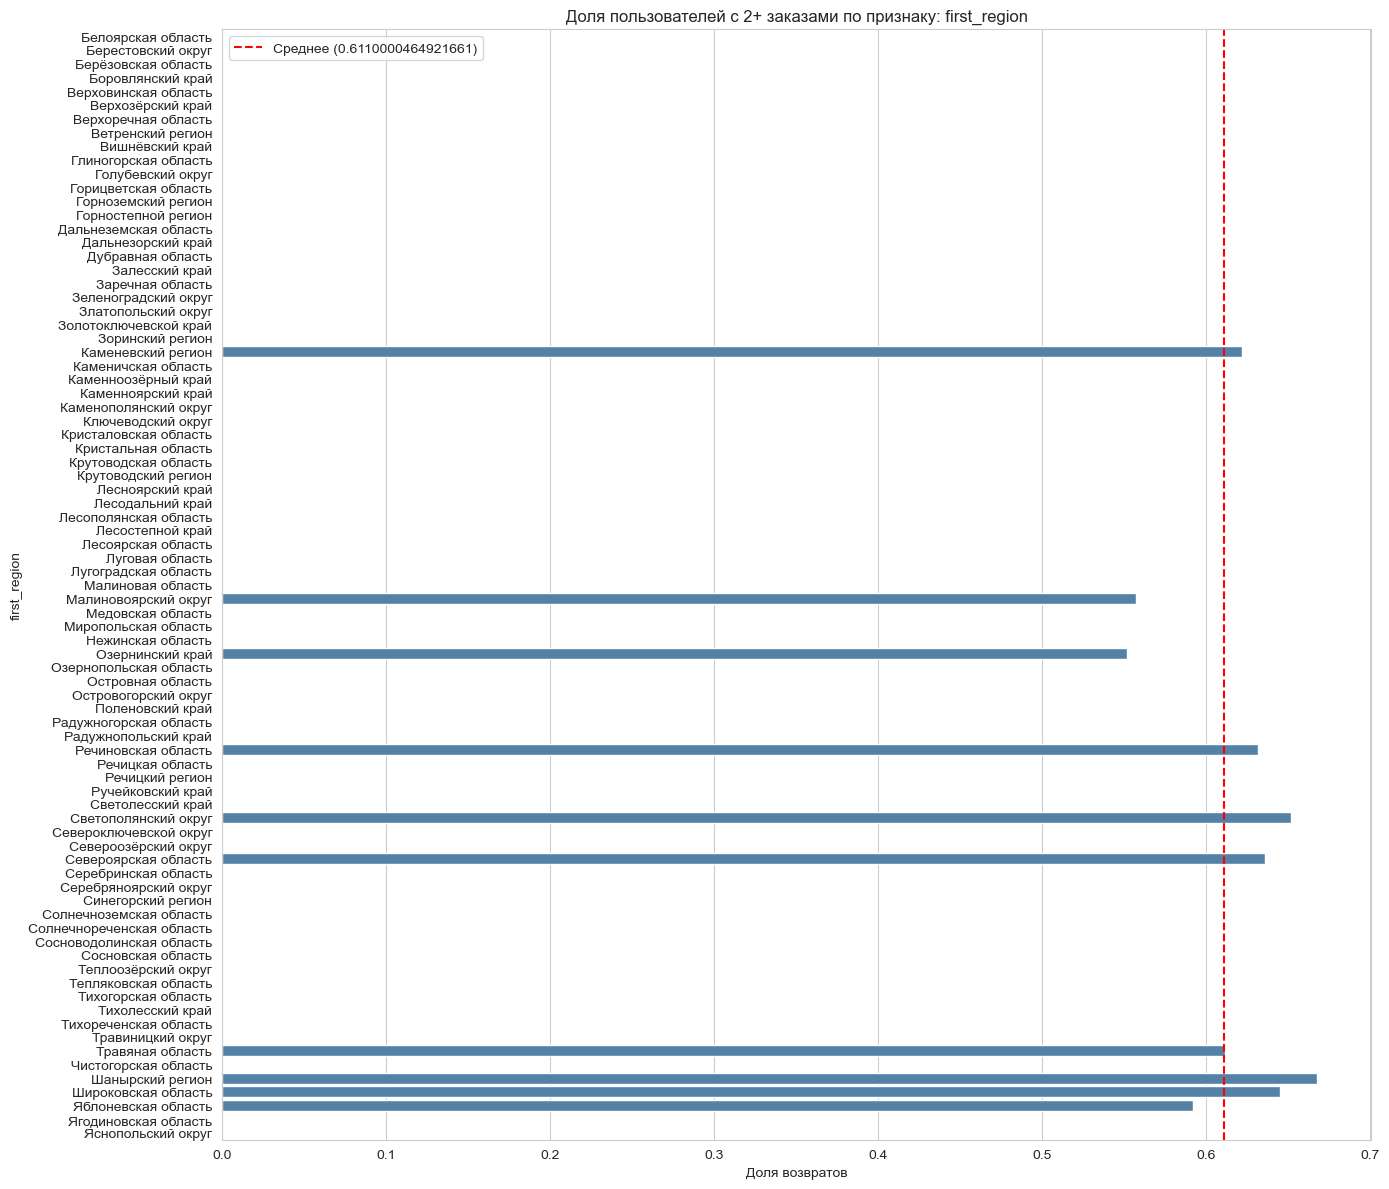

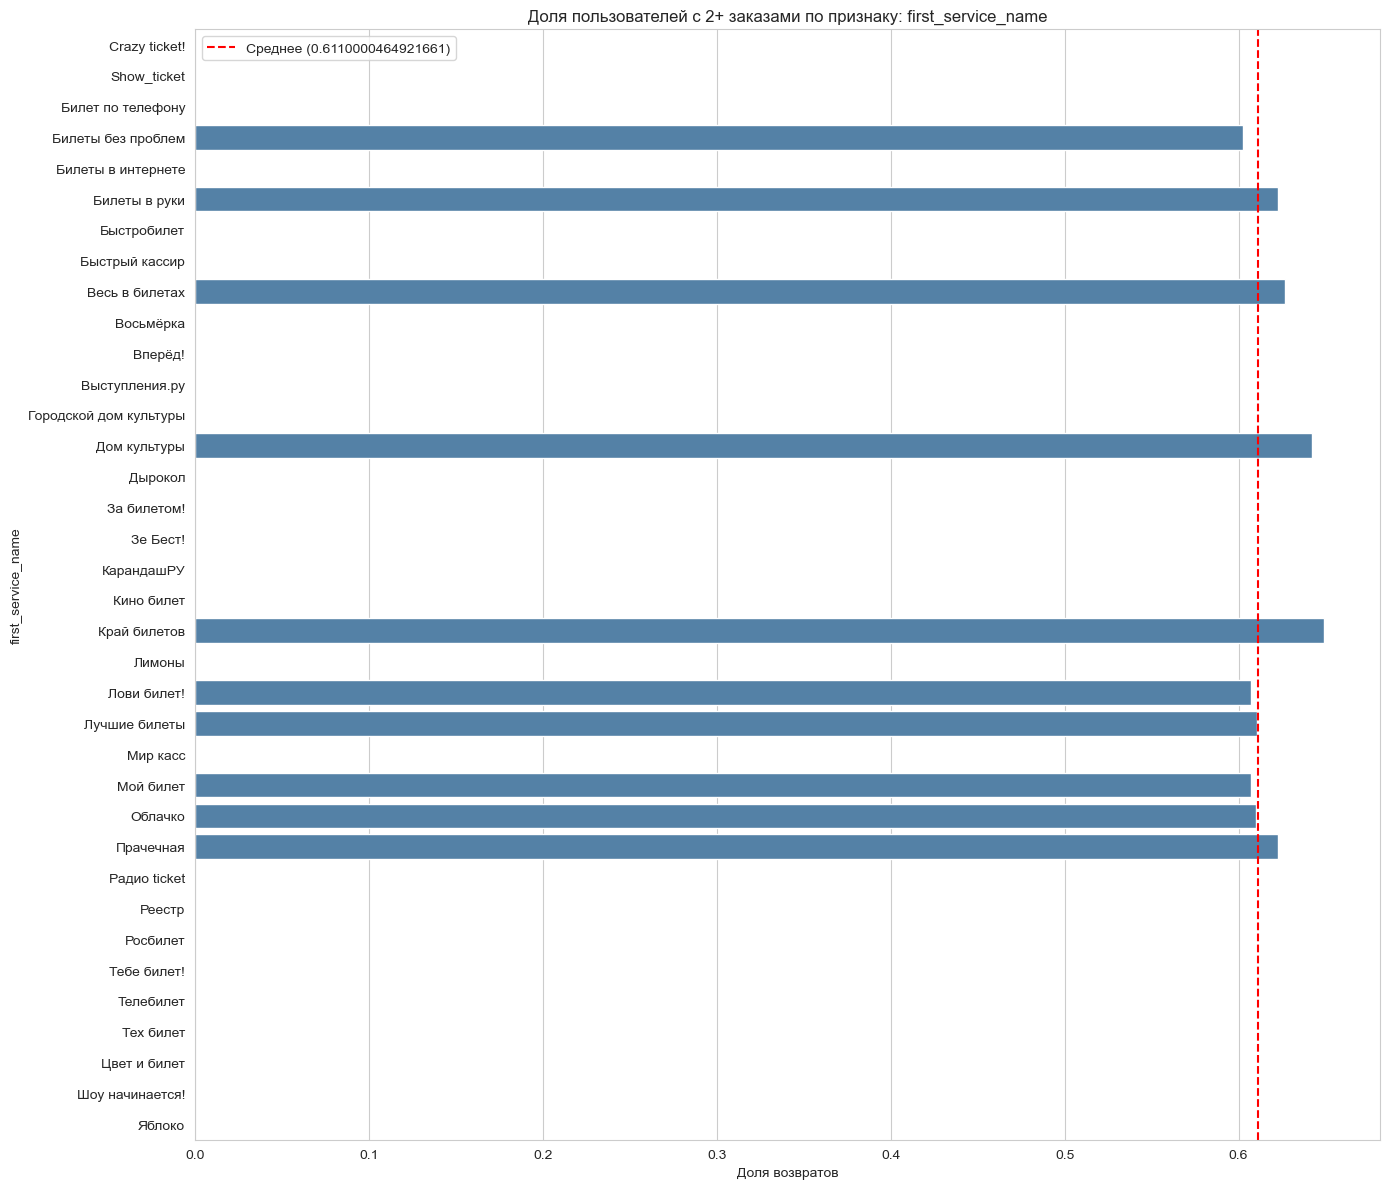

In [ ]:
global_return_rate = user_profile_clean['is_two'].mean()
features = [
    'first_event_type',
    'first_device_type',
    'first_region',
    'first_service_name'
]
for feature in features:
    segment_stats = user_profile_clean.groupby(feature, observed=True).agg(
        total_users=('user_id', 'size'),
        return_rate=('is_two', 'mean')
    ).sort_values('total_users', ascending=False)

    top_segments = segment_stats.head(10)

    if feature in ['first_region', 'first_service_name']:
        figsize = (14, 12)
    else:
        figsize = (14, 8)
    plt.figure(figsize=figsize)
    sns.barplot(data=top_segments.reset_index(), x='return_rate', y=feature, color='steelblue')
    plt.axvline(global_return_rate, color='red', linestyle='--', 
                label=f'Среднее ({global_return_rate})')
    plt.title(f'Доля пользователей с 2+ заказами по признаку: {feature}')
    plt.xlabel('Доля возвратов')
    plt.ylabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()

Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
По всем четырём признакам первого заказа выявлены сегменты с повышенной лояльностью:
Тип мероприятия (first_event_type)
Лидер: «фильм» — доля возвратов +-80%, что значительно выше среднего (61%).
Далее следуют: «театр», «стендап», «выставки» — все в диапазоне 63–65%.
Наименее лояльны: «спорт» (+-55%) и «ёлки» (+-55%).
Билетный оператор (first_service_name)
Наиболее лояльные:
«Край билетов» — +-65%
«Облачко» — +-65%
«Прачечная» — +-65%
«Мир касс» — +-65%
Наименее лояльный: «Билеты без проблем» — +-60%, несмотря на то что это самый популярный оператор.
Регион (first_region)
Множество регионов показывают долю возвратов >60%, некоторые — до 65–70%.
Нет единого лидера, но регионы вроде «Ясеневский округ», «Светополянский округ» и «Чистогорская область» демонстрируют высокую лояльность.
Устройство (first_device_type)
Разницы нет: mobile и desktop — оба около 61%, что соответствует среднему по выборке.
Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?
Да, такие сегменты есть. Они характеризуются тем, что:

Привлекают пользователей (или имеют достаточный объём),
И одновременно показывают долю возвратов выше 61%.
Ключевые успешные «точки входа»:

«фильм» — несмотря на то что это не самая популярная категория (в топ-10 по числу пользователей), она имеет самую высокую лояльность — 80%. Это означает, что пользователи, начавшие с фильмов, наиболее склонны становиться постоянными клиентами.
Операторы «Облачко», «Край билетов», «Прачечная» — не самые крупные, но их пользователи возвращаются чаще, чем в среднем. Это делает их эффективными каналами удержания, даже если они не привлекают больше всего новых клиентов.
Некоторые регионы (например, «Ясеневский округ», «Чистогорская область») — показывают высокую лояльность при умеренном объёме.
Эти сегменты можно считать успешными «точками входа», так как они не только привлекают пользователей, но и способствуют их удержанию.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1
«Пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты».

Гипотеза не подтверждается.
Доля возвратов (2+ заказов) для пользователей, начавших с «концерты»: +-61–62%
Доля возвратов для пользователей, начавших с «спорт»: +-55%
Таким образом, пользователи концертов возвращаются чаще, чем пользователи спортивных мероприятий.
Гипотеза опровергнута.

Гипотеза 2
«В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах».

Гипотеза не подтверждается.
Анализ показывает:
Лидер по числу пользователей — «Каменевский регион» (+-33% всех пользователей), однако его доля возвратов — около 60%, что на уровне или даже немного ниже среднего (61.1%).
Среди регионов с наиболее высокой лояльностью (65–70%) — такие как «Ясеневский округ», «Чистогорская область» — они не входят в топ-3 по объёму.
Это означает, что масштаб активности в регионе не коррелирует с уровнем удержания. Наоборот, менее массовые регионы иногда демонстрируют более высокую лояльность.
Гипотеза опровергнута.



---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


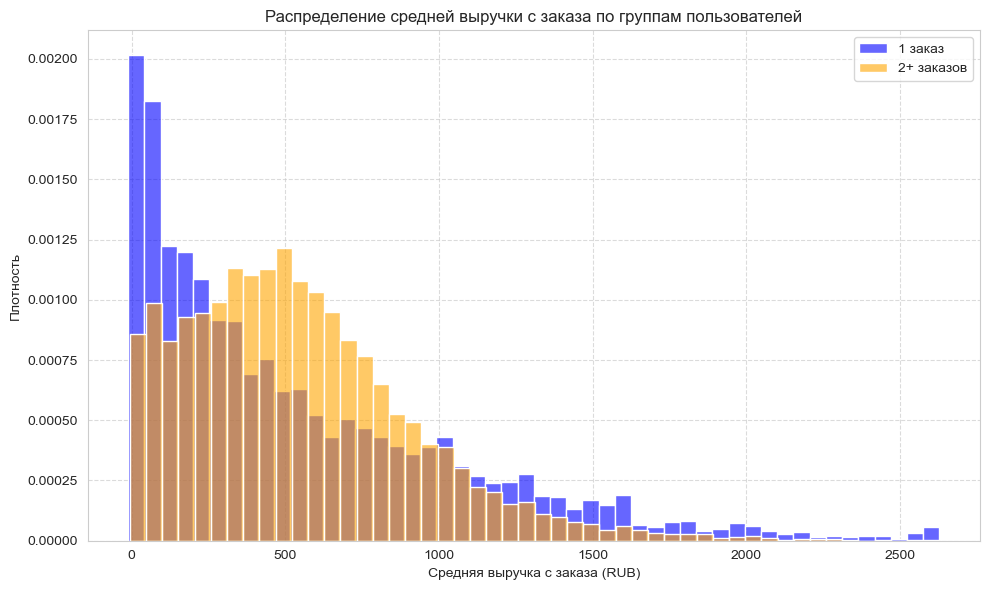

In [ ]:
single_users = user_profile_clean[user_profile_clean['total_orders'] == 1]['avg_revenue_rub']
repeat_users = user_profile_clean[user_profile_clean['total_orders'] >= 2]['avg_revenue_rub']

plt.figure(figsize=(10, 6))
sns.histplot(single_users, bins=50, alpha=0.6, label='1 заказ', stat='density', color='blue')
sns.histplot(repeat_users, bins=50, alpha=0.6, label='2+ заказов', stat='density', color='orange')
plt.title('Распределение средней выручки с заказа по группам пользователей')
plt.xlabel('Средняя выручка с заказа (RUB)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
Пользователи с 1 заказом (синий):
Основная масса распределена в диапазоне 0–800 рублей, с пиком плотности около 300–500 рублей.
Есть длинный «хвост» до 2500+ рублей — это единичные дорогие заказы.
Пользователи с 2+ заказами (оранжевый):
Концентрация сосредоточена в более узком диапазоне — 0–600 рублей, с пиком плотности около 200–400 рублей.
Доли в области >1000 рублей значительно ниже, чем у одноразовых пользователей.

Есть ли различия между группами?
Да, различия выражены явно:

Смещение влево:
Распределение для пользователей с 2+ заказами сдвинуто в сторону меньших значений — они чаще покупают билеты по умеренным ценам.
Форма распределения:
Группа «1 заказ» имеет более широкое и растянутое распределение — от дешёвых до очень дорогих заказов.
Группа «2+ заказов» — более компактное и симметричное, с быстрым спадом после 600 рублей.

Поведенческая интерпретация:
Пользователи с одним заказом чаще делают разовые, иногда импульсивные или подарочные покупки по высокой цене.
Пользователи с повторными заказами — регулярные клиенты, предпочитающие умеренные цены и формирующие стабильный поток выручки.
Это означает, что высокая цена заказа не способствует лояльности, а наоборот — основной вклад в удержание вносит аудитория с умеренными чеками.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


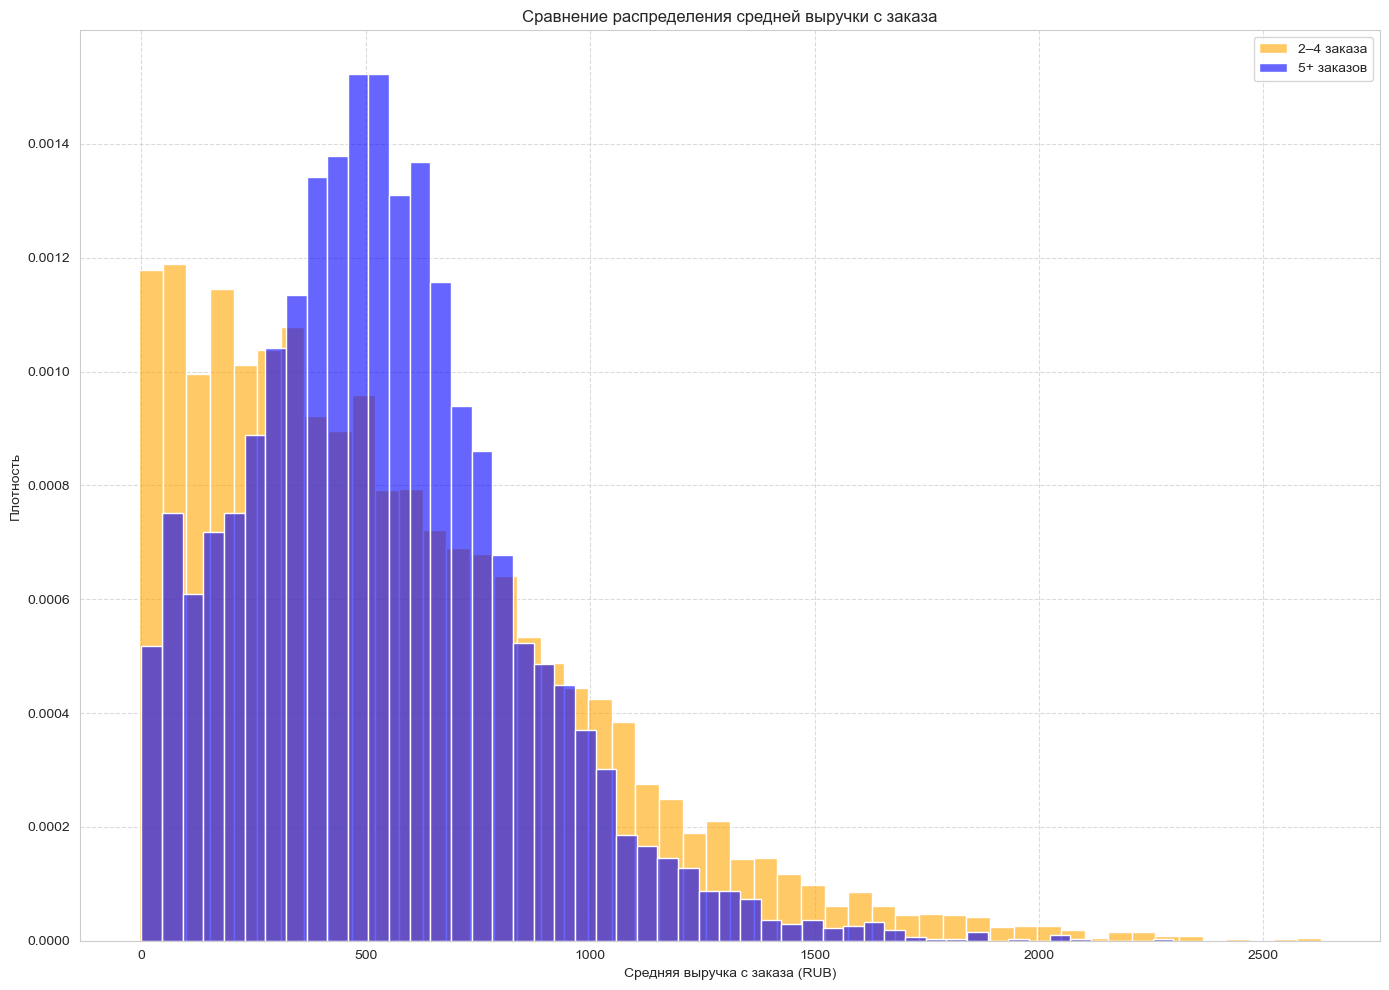

Средняя выручка с заказа:
  2–4 заказа:   551.0800170898438 RUB
  5+ заказов:   536.605712890625 RUB


In [ ]:
group_2_4 = user_profile_clean[
    (user_profile_clean['total_orders'] >= 2) & 
    (user_profile_clean['total_orders'] <= 4)
]['avg_revenue_rub']

group_5_plus = user_profile_clean[
    user_profile_clean['total_orders'] >= 5
]['avg_revenue_rub']


plt.figure(figsize=(14, 10))
sns.histplot(group_2_4, bins=50, alpha=0.6, label='2–4 заказа', stat='density', color='orange')
sns.histplot(group_5_plus, bins=50, alpha=0.6, label='5+ заказов', stat='density', color='blue')

plt.title('Сравнение распределения средней выручки с заказа')
plt.xlabel('Средняя выручка с заказа (RUB)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Вывод средних значений
print(f"Средняя выручка с заказа:")
print(f"  2–4 заказа:   {group_2_4.mean()} RUB")
print(f"  5+ заказов:   {group_5_plus.mean()} RUB")

Есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

Да, различия есть — но они незначительны.
Средняя выручка для группы 2–4 заказа: 551.08 RUB
Средняя выручка для группы 5+ заказов: 536.61 RUB
Разница составляет всего 14.47 RUB.

На графике видно:
Оба распределения имеют почти идентичную форму — пик около 300–500 RUB, длинный хвост вправо.
Распределение для 5+ заказов слегка смещено влево, что соответствует немного меньшему среднему значению.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

  ticket_segment  total_users  return_rate
0     1–2 билета         2422     0.513212
1     2–3 билета         9370     0.732337
2    3–5 билетов         9056     0.542513
3     5+ билетов          661     0.187595


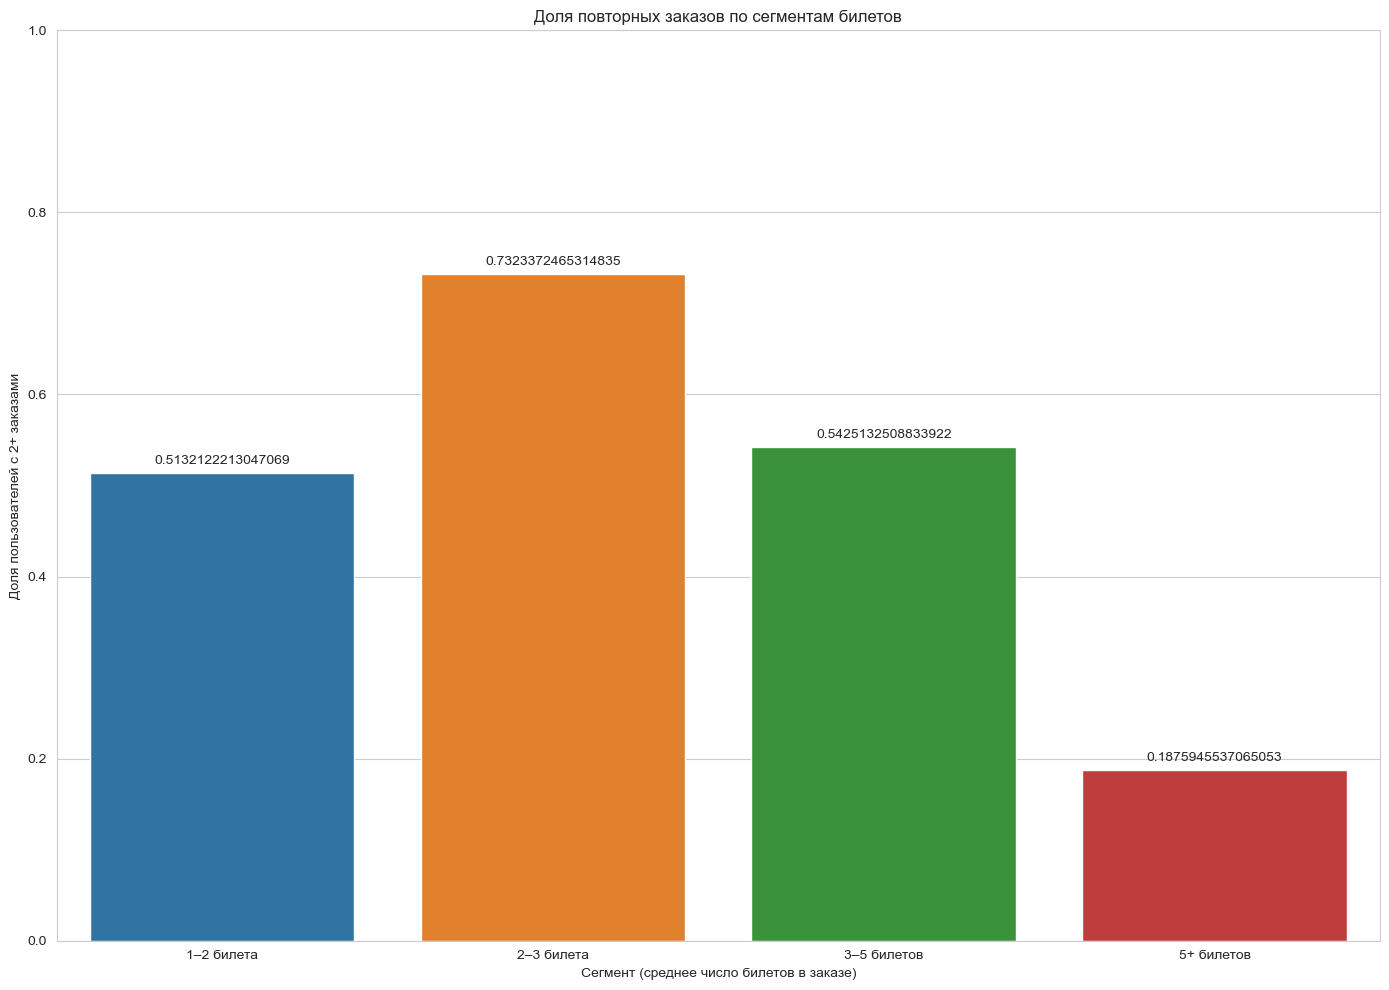

In [ ]:
user_profile_clean['ticket_segment'] = pd.cut(
    user_profile_clean['avg_tickets_count'],
    bins=[0, 2, 3, 5, float('inf')],
    labels=['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов'],
    right=False
)

segment_stats = user_profile_clean.groupby('ticket_segment', observed=True).agg(
    total_users=('user_id', 'size'),
    return_rate=('is_two', 'mean')
).reset_index()
print(segment_stats)

plt.figure(figsize=(14, 10))
sns.barplot(data=segment_stats, x='ticket_segment', y='return_rate', hue='ticket_segment', legend=False)
plt.title('Доля повторных заказов по сегментам билетов')
plt.xlabel('Сегмент (среднее число билетов в заказе)')
plt.ylabel('Доля пользователей с 2+ заказами')
plt.ylim(0, 1)
for idx, row in segment_stats.iterrows():
    plt.text(idx, row['return_rate'] + 0.01, f"{row['return_rate']}", ha='center')
plt.tight_layout()
plt.show()

Как распределены пользователи по сегментам — равномерно или сконцентрировано?
Распределение сильно сконцентрировано.

Сегмент «2–3 билета» — самый крупный: 9 370 пользователей.
Сегмент «3–5 билетов» — второй по размеру: 9 056 пользователей.
Сегмент «1–2 билета» — 2 422 пользователя.
Сегмент «5+ билетов» — самый маленький: всего 661 пользователь.
Таким образом, подавляющее большинство пользователей покупает 2–5 билетов в среднем за заказ, что соответствует поведению пары, семьи или небольшой компании. Групповые покупки (5+ билетов) — редкость.

Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
Да, наблюдается резкая разница между сегментами:

Сегмент
Доля повторных заказов
1–2 билета 51.3%
2–3 билета 73.2% - максимум
3–5 билетов 54.3%
5+ билетов 18.8% - минимум

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


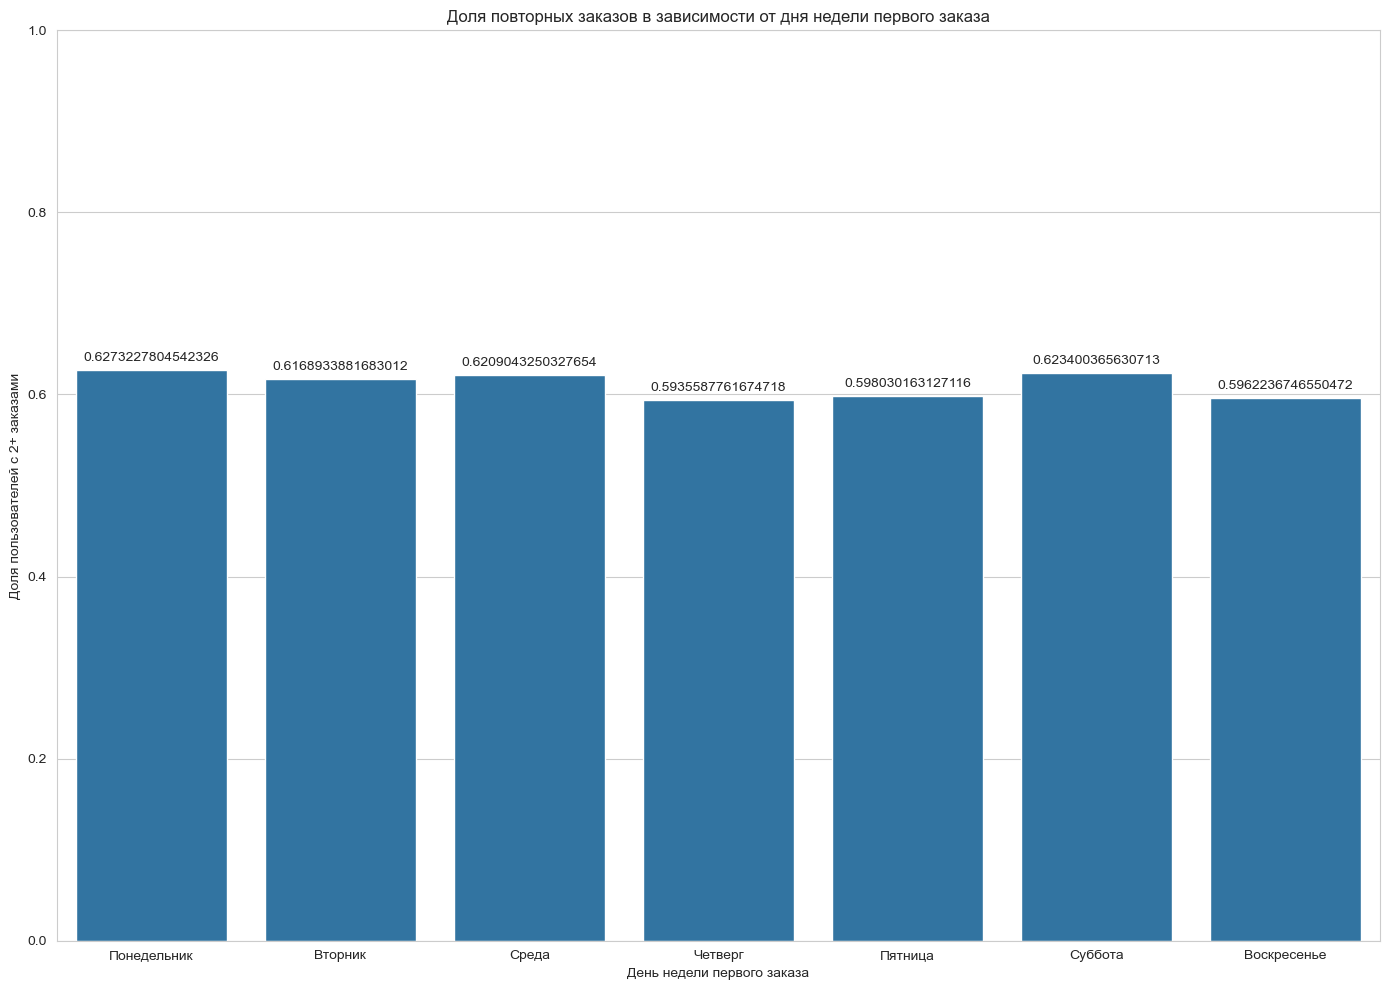

                      total_users  return_rate
first_order_dow_name                          
Понедельник                  2906     0.627323
Вторник                      3161     0.616893
Среда                        3052     0.620904
Четверг                      3105     0.593559
Пятница                      3249     0.598030
Суббота                      3282     0.623400
Воскресенье                  2754     0.596224


In [ ]:
user_profile_clean['first_order_dow'] = pd.to_datetime(user_profile_clean['first_order_date']).dt.dayofweek
dow_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
user_profile_clean['first_order_dow_name'] = user_profile_clean['first_order_dow'].map(lambda x: dow_names[x])

dow_stats = user_profile_clean.groupby('first_order_dow_name', observed=True).agg(
    total_users=('user_id', 'size'),
    return_rate=('is_two', 'mean')
).reindex(dow_names) 

plt.figure(figsize=(14, 10))
sns.barplot(data=dow_stats.reset_index(), x='first_order_dow_name', y='return_rate')
plt.title('Доля повторных заказов в зависимости от дня недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля пользователей с 2+ заказами')
plt.ylim(0, 1)
for idx, row in dow_stats.reset_index().iterrows():
    plt.text(idx, row['return_rate'] + 0.01, f"{row['return_rate']}", ha='center')
plt.tight_layout()
plt.show()
print(dow_stats)

Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

Да, влияет — но незначительно.

Разница между самой высокой и самой низкой долей возвратов составляет всего 3.4:

Максимум — 62.7% (понедельник)
Минимум — 59.4% (четверг)
На графике видно:

Дни с наибольшей лояльностью: понедельник, среда, суббота — доля возвратов +-62–63%
Дни с наименьшей лояльностью: четверг, пятница, воскресенье — доля возвратов +-59–60%
Это означает, что:

Нет явного «лучшего» или «худшего» дня для первого заказа.
Поведение пользователей почти одинаково по всем дням недели — разброс минимальный.
Различия не являются статистически значимыми для принятия бизнес-решений.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [ ]:
group_2_4 = user_profile_clean[
    (user_profile_clean['total_orders'] >= 2) & 
    (user_profile_clean['total_orders'] <= 4)
]

group_5_plus = user_profile_clean[
    user_profile_clean['total_orders'] >= 5
]
avg_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
avg_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()
print("Средний интервал между заказами:")
print(f"2–4 заказа:{avg_interval_2_4} дней")
print(f"5+ заказов:{avg_interval_5_plus} дней")

Средний интервал между заказами:
2–4 заказа:21.053546446558478 дней
5+ заказов:9.822160220862786 дней


Пользователи, совершившие 5 и более заказов, в среднем делают следующую покупку через 9.8 дней.
Пользователи с 2–4 заказами возвращаются значительно реже — в среднем через 21.1 дня.
Разница составляет более чем в 2 раза.

Это означает, что частота повторных покупок напрямую связана с уровнем лояльности:
чем короче интервал между заказами, тем выше вовлечённость и вероятность долгосрочного удержания.

Пользователи из группы «5+ заказов» формируют стабильную привычку пользоваться сервисом — они возвращаются почти каждую неделю, что указывает на высокую вовлечённость и удовлетворённость.
Напротив, пользователи с интервалом в 3 недели и более находятся на грани оттока — их поведение менее регулярно.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [ ]:
!pip install phik

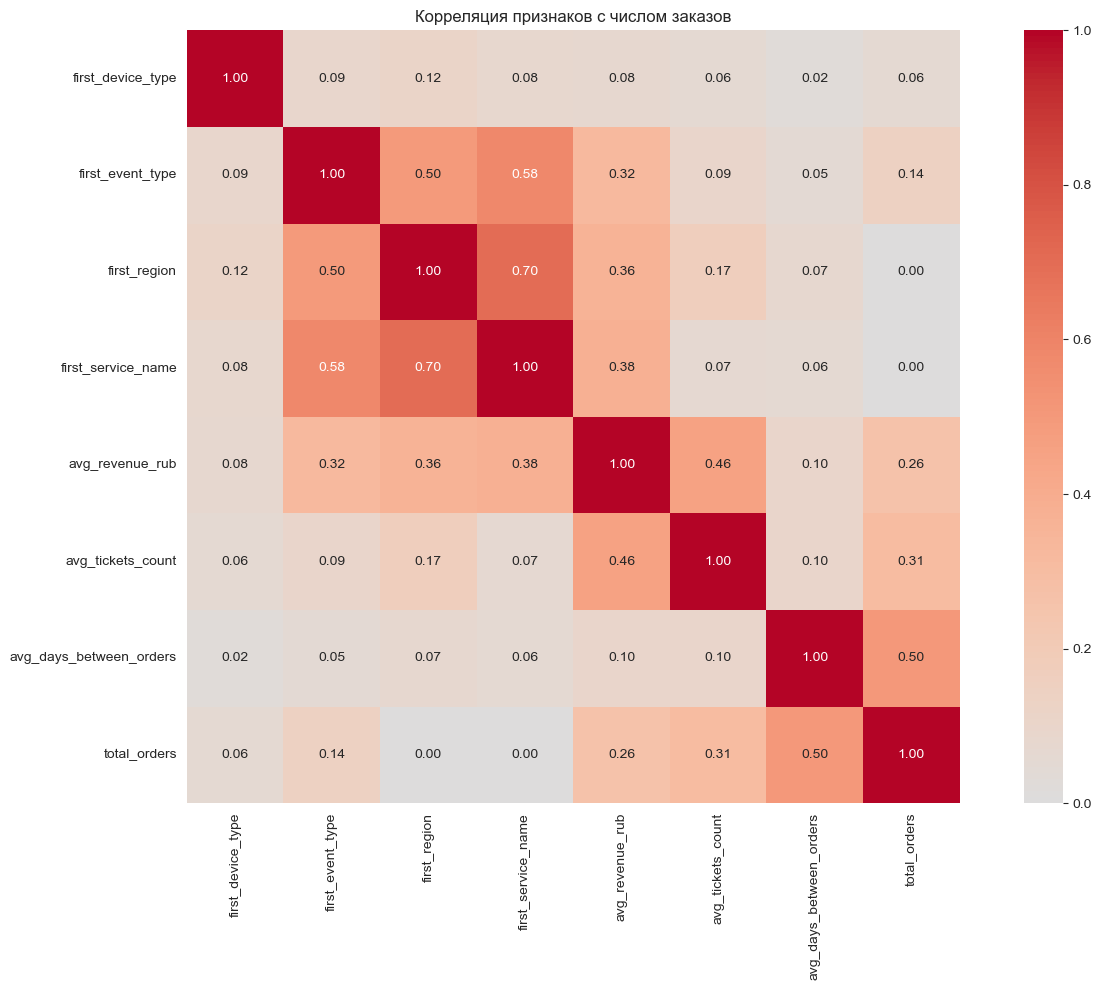


Коэффициенты корреляции с total_orders:
avg_days_between_orders    0.504901
avg_tickets_count          0.307550
avg_revenue_rub            0.264765
first_event_type           0.144570
first_device_type          0.062397
first_region               0.000000
first_service_name         0.000000
Name: total_orders, dtype: float64


In [ ]:
import phik
cols_for_correlation = [
    'first_device_type',
    'first_event_type',
    'first_region',
    'first_service_name',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'total_orders'
]

df_corr = user_profile_clean[cols_for_correlation].copy()
interval_cols = ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']
correlation_matrix = df_corr.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Корреляция признаков с числом заказов')
plt.tight_layout()
plt.show()
phi_with_total = correlation_matrix['total_orders'].drop('total_orders').sort_values(key=abs, ascending=False)
print("\nКоэффициенты корреляции с total_orders:")
print(phi_with_total)

Самые сильные связи:
avg_days_between_orders — 0.50
Чем короче средний интервал между заказами, тем больше общее число заказов. Это самый сильный фактор — прямая связь между частотой покупок и лояльностью.
avg_tickets_count — 0.31
Пользователи, покупающие в среднем больше билетов за заказ, склонны совершать больше заказов. Особенно заметно в сегменте «2–3 билета».
avg_revenue_rub — 0.26
Связь слабее, но положительная — пользователи с более высокой средней выручкой по заказу чаще совершают повторные покупки.

Слабые или отсутствующие связи:
first_event_type — 0.14
Есть небольшая связь — например, пользователи, начавшие с «фильмов» или «театра», чаще возвращаются, но это влияние не доминирующее.
first_device_type — 0.06
Устройство первого заказа (mobile/desktop) почти не влияет на количество заказов.
first_region и first_service_name — 0.00
Эти признаки не показывают статистически значимой связи с числом заказов. Это означает, что:
География не определяет активность.
Выбор оператора не влияет на лояльность в долгосрочной перспективе.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Основные результаты анализа
1.Распределение пользователей:
61.1% пользователей совершили 2+ заказа, 27.9% — 5+ заказов.
Медианное число заказов — 2, что указывает на высокий уровень удержания.
2. Признаки первого заказа и возврат

Наиболее лояльны пользователи, начавшие с фильмов (80% возвратов), театра и стендапа (63–65%).
Пользователи концертов (44% входа) показывают возвратность на уровне среднего (61%), а спорта — ниже среднего (55%).
Устройство, регион и оператор слабо влияют на лояльность (корреляция < 0.07).

3.Выручка и количество билетов

Средняя выручка с заказа у лояльных пользователей ниже (536 RUB у 5+ заказов vs 551 RUB у 2–4 заказов), что говорит: удержание формируют клиенты с умеренными чеками.
Оптимальный сегмент по билетам — 2–3 билета: доля возвратов 73.2% (максимум).
5+ билетов — аномально низкая лояльность (18.8%), вероятно, разовые корпоративные/групповые покупки.

4.Временные характеристики

День недели первого заказа не влияет на удержание (разброс доли возвратов — всего 3.3%: от 59.4% до 62.7%).
Ключевой фактор — средний интервал между заказами:
У 5+ заказов — 9.8 дней,
У 2–4 заказов — 21.1 дней.
Чем чаще покупки — тем выше лояльность.

5.Корреляционный анализ (phi_k)
Сильнее всего с числом заказов связаны:

Интервал между заказами (0.50),
Среднее число билетов (0.31),
Средняя выручка (0.26).
Категориальные признаки первого заказа (тип мероприятия, устройство, регион, оператор) показали слабую или нулевую корреляцию.
Рекомендации
Фокус на удержании, а не на привлечении
Основной вклад в выручку вносят пользователи с умеренными чеками (200–600 RUB) и 2–3 билетами. Для них нужно создавать программы лояльности (например, накопительные скидки).
Активизировать групповые покупки
Сегмент «5+ билетов» имеет огромный потенциал (высокий чек), но крайне низкую лояльность. Предложите спецусловия для повторных групповых бронирований (например, «приведи компанию — получи скидку на следующий раз»).
Сократить интервал между первым и вторым заказом
Запустите автоматизированные рекомендации через 7–10 дней после первой покупки — критический период для формирования привычки.
Переосмыслить промо-стратегию
Фильмы — лучший триггер для лояльности, но в данных они редки. Увеличьте долю сеансов в рекомендациях.
Спорт — неэффективен для удержания. Снижайте маркетинговые затраты на это направление.
Игнорировать географию и оператора
Эти факторы не влияют на долгосрочную активность. Ресурсы лучше тратить на персонализацию по поведению, а не на региональные/партнёрские кампании.


In [ ]:
!pip freeze > requirements.txt

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**